In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import *

# 1. Spark application (70 баллов в сумме)

In [2]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [3]:
!hdfs dfs -rm -r movielens
!hdfs dfs -mkdir -p ./movielens
!hdfs dfs -put ./movielens .

Deleted movielens


In [4]:
conf = SparkConf().set("spark.executor.instances", "2")

spark = SparkSession.builder.config(
    conf=conf
).master(master="yarn").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 20:15:20 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


Скрин из UI yarn:

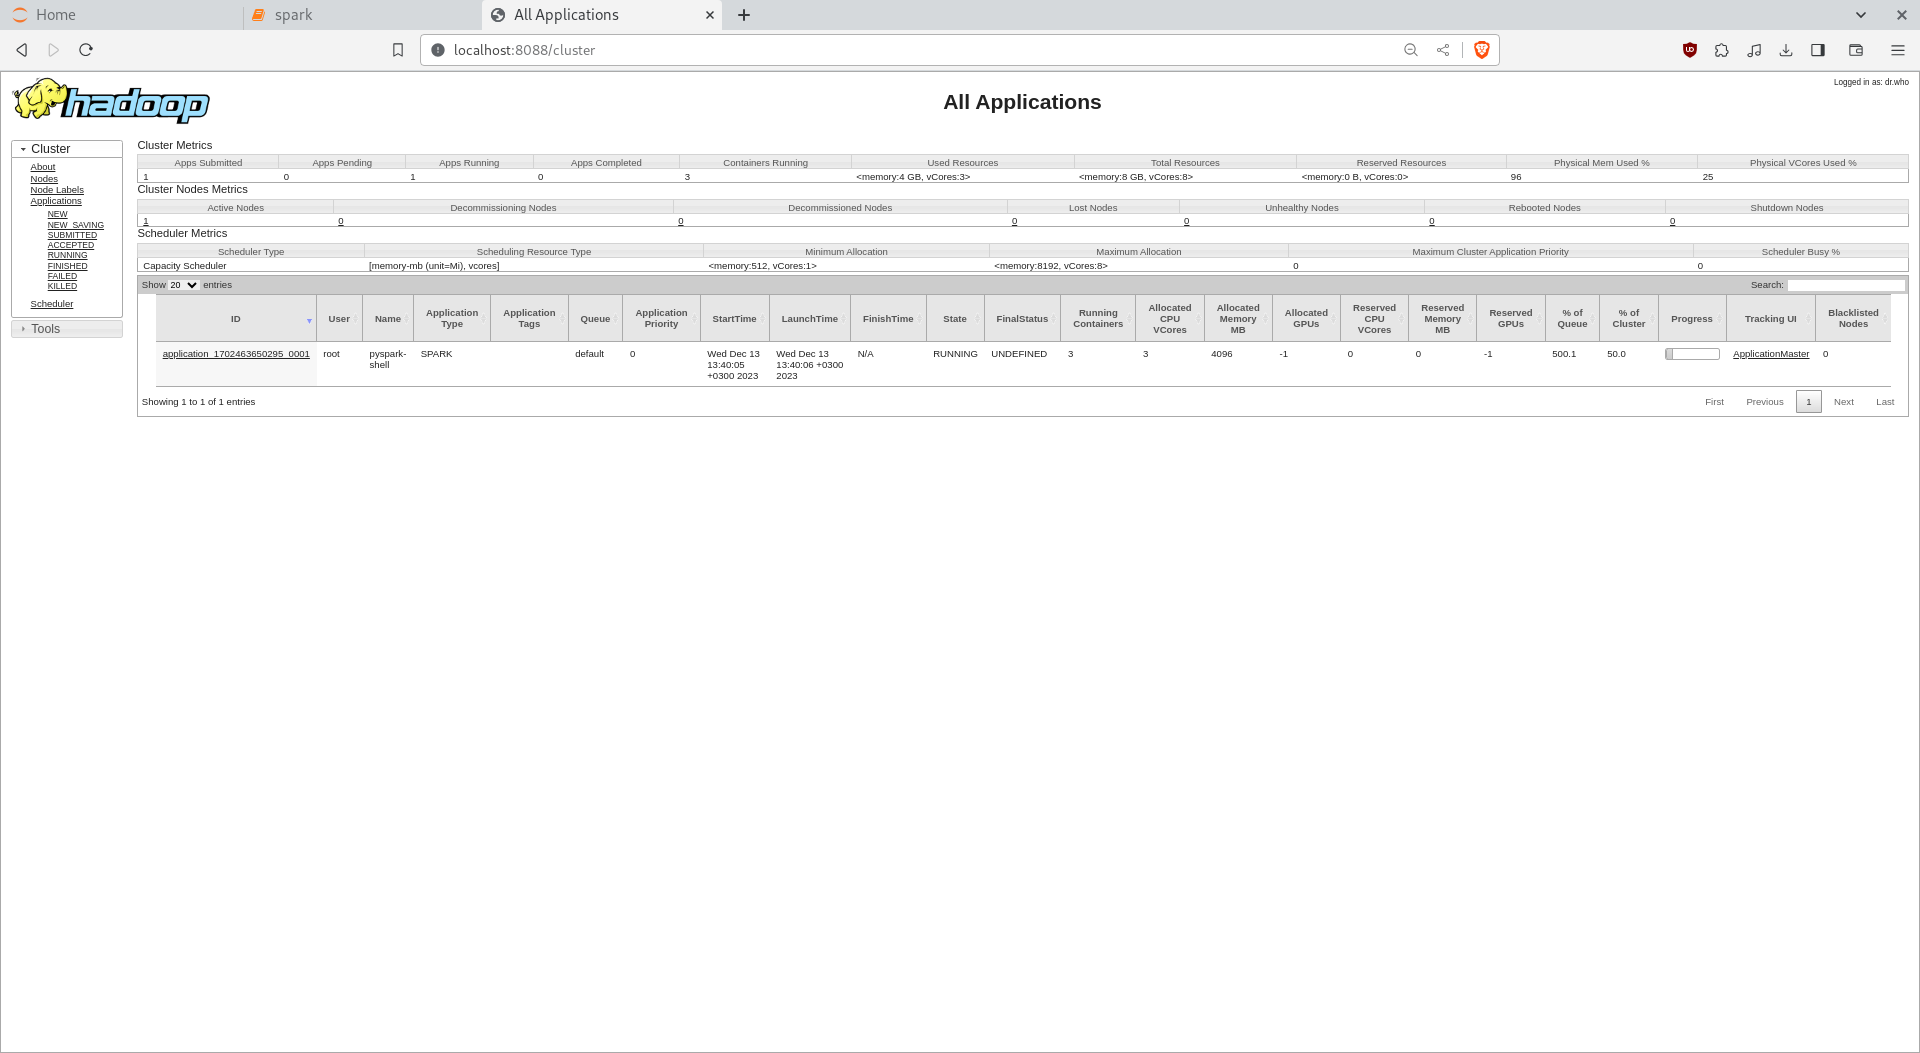

Скрин из UI spark:

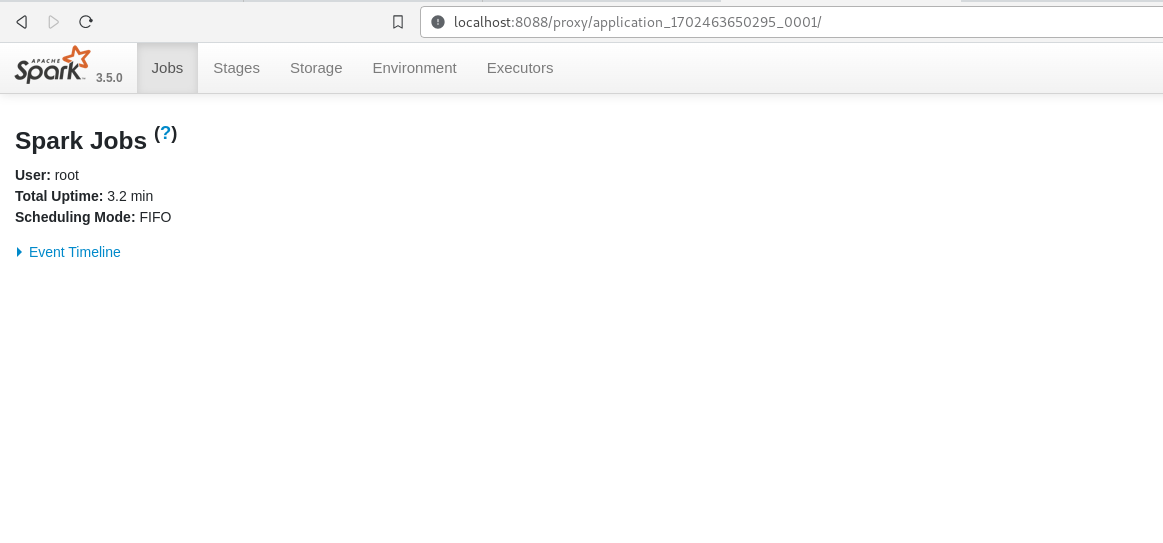

In [5]:
ratings_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", DoubleType()),
    StructField("timestamp", LongType()),
])

ratings_df = spark.read.format("csv").option("header", "True")\
    .schema(ratings_schema).load("movielens/ratings.csv")

In [6]:
tags_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("tag", StringType()),
    StructField("timestamp", LongType()),
])

tags_df = spark.read.format("csv").option("header", "True")\
    .schema(tags_schema).load("movielens/tags.csv")

количество строчек в ratings

In [7]:
ratings_df.count()

100836

количество строчек в tags

In [8]:
tags_df.count()

3683

Выполненные job-ы в UI spark:

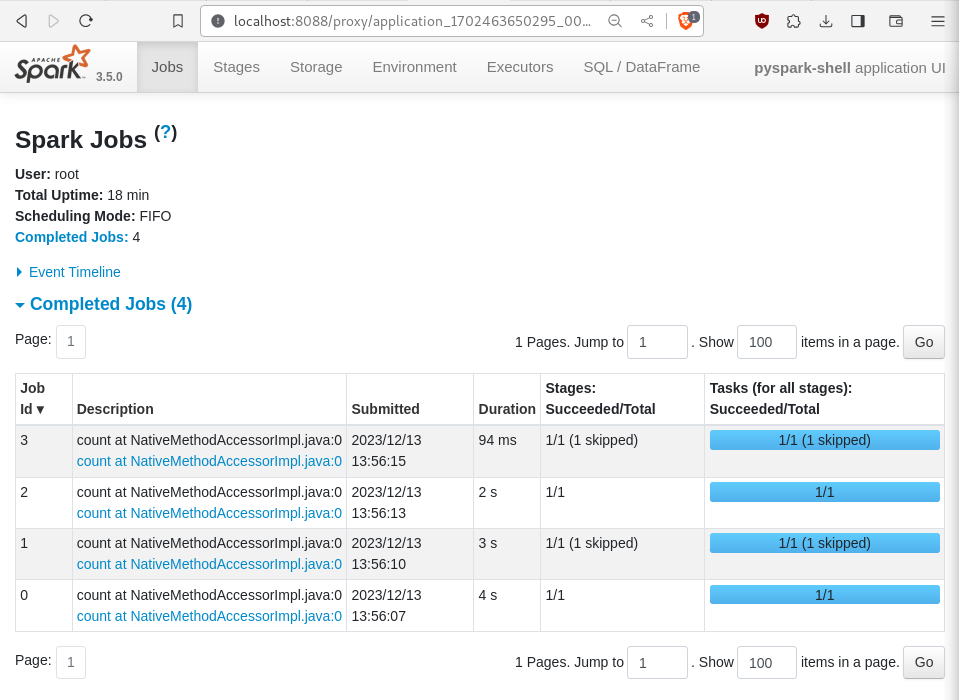

Каждый вызов count привел к запуску 2х job: первая - считывание csv файла, вторая - видимо непосредственно подсчет количества строк.

Например для ratings:

- первая job-а сотоит из одного stage и одной таски:
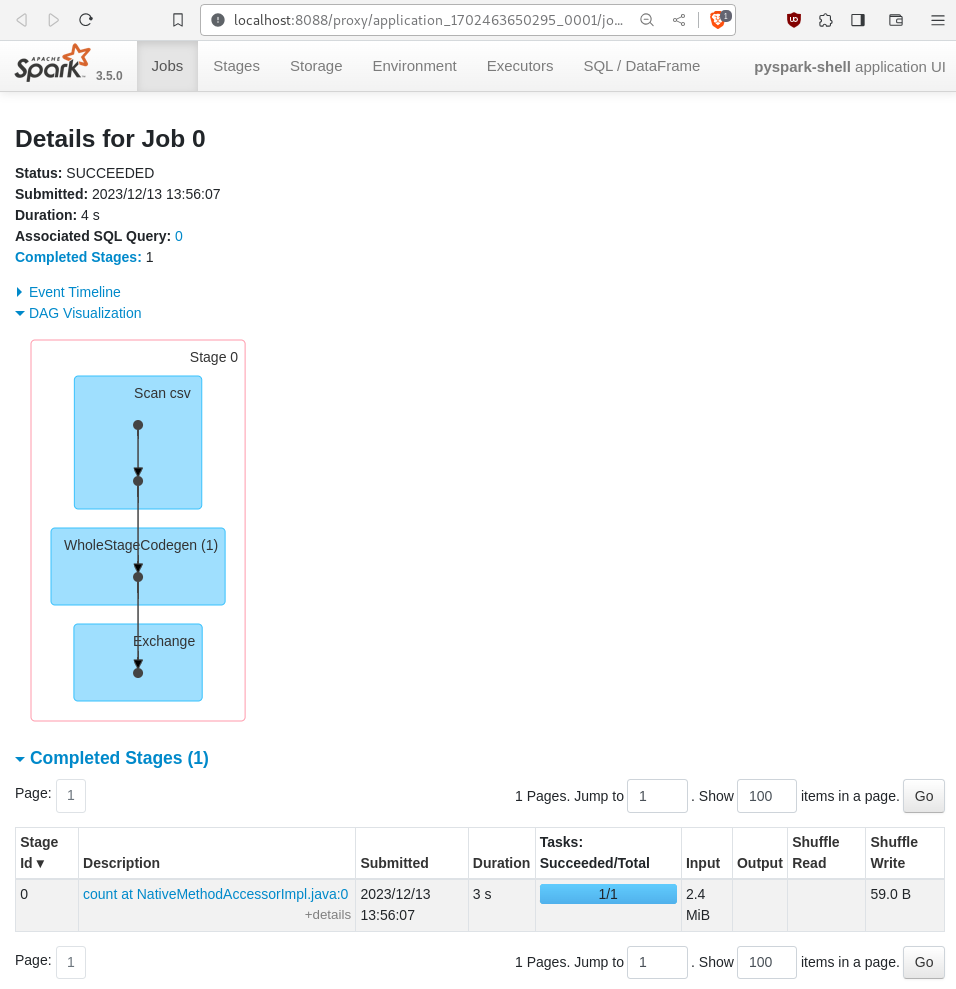

- вторая job-а сотоит из двух stage и двух тасок, однако первый stage пропускается поскольку уже был выполнен и видимо закеширован:
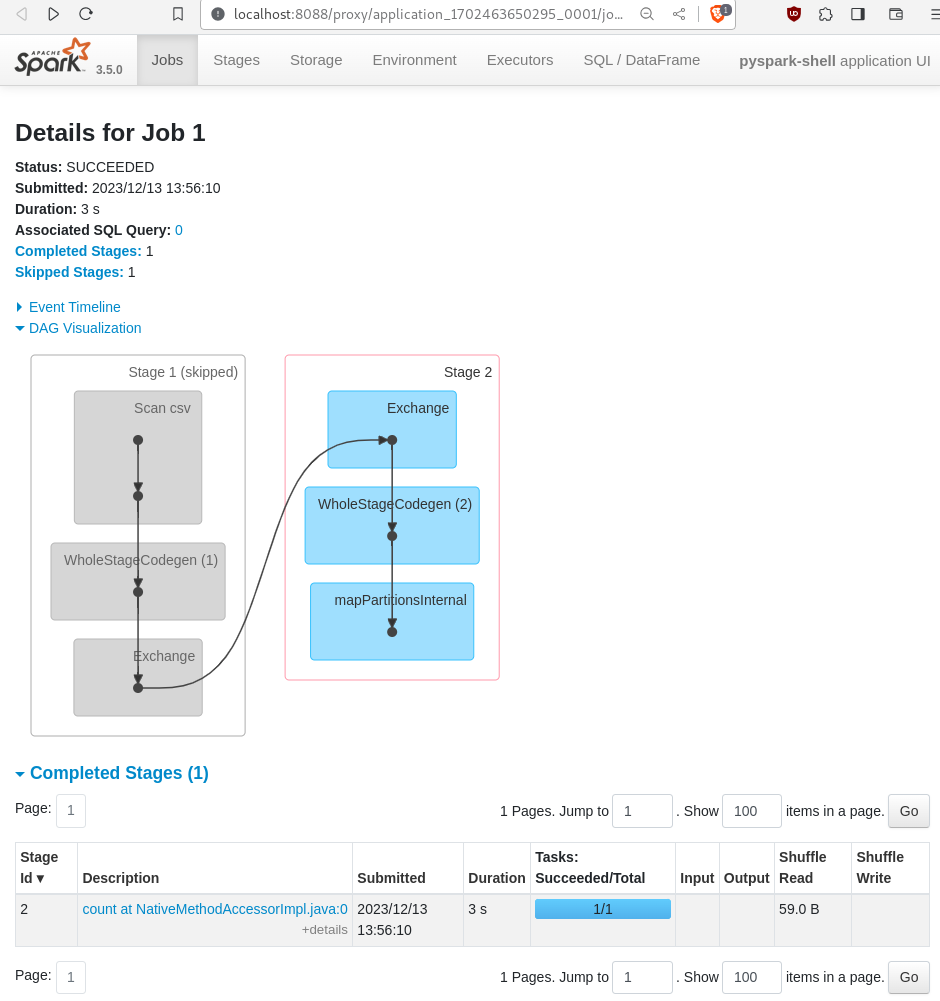

# 2. Работа с данными (30 баллов в сумме)

In [9]:
ratings_df

DataFrame[userId: int, movieId: int, rating: double, timestamp: bigint]

In [10]:
tags_df

DataFrame[userId: int, movieId: int, tag: string, timestamp: bigint]

In [11]:
# количество уникальных юзеров
ratings_df.select("userId").distinct().count()

610

In [12]:
# количество уникальных фильмов
ratings_df.select("movieId").distinct().count()

9724

In [13]:
# количество оценок >= 4.0
ratings_df.filter(f.col("rating") >= 4.0).count()

48580

In [14]:
# топ 100 фильмов с самым высоким рейтингом
ratings_df.groupBy(f.col("movieId"))\
    .agg(f.avg(f.col("rating")).alias("avg_rating"))\
    .orderBy("avg_rating", ascending=False)\
    .show(100)

+-------+----------+
|movieId|avg_rating|
+-------+----------+
|  80124|       5.0|
|  74226|       5.0|
| 175387|       5.0|
|    148|       5.0|
| 158027|       5.0|
|  67618|       5.0|
|  42556|       5.0|
| 142444|       5.0|
|  44943|       5.0|
|  27523|       5.0|
| 113829|       5.0|
|   3073|       5.0|
| 152711|       5.0|
| 132333|       5.0|
|     53|       5.0|
|  27704|       5.0|
| 147300|       5.0|
| 187717|       5.0|
|    633|       5.0|
|   8238|       5.0|
|    876|       5.0|
| 120138|       5.0|
|  53578|       5.0|
| 163072|       5.0|
| 160644|       5.0|
| 172909|       5.0|
|   5490|       5.0|
| 172583|       5.0|
|   2972|       5.0|
|   2196|       5.0|
|  25887|       5.0|
| 118834|       5.0|
|   3795|       5.0|
| 156025|       5.0|
|   3941|       5.0|
| 120130|       5.0|
|    626|       5.0|
|   1349|       5.0|
|  26928|       5.0|
| 122092|       5.0|
|  40491|       5.0|
|  71268|       5.0|
| 167064|       5.0|
|  99636|       5.0|
|  25906|    

In [25]:
# средняя разница во времени в секундах между временем тегирования пользователя
# данного фильма и временем, когда пользователь поставил оценку фильму
ratings_with_tags_df = ratings_df.alias("r").join(
    tags_df.alias("t"),
    on=["userId", "movieId"],
    how="inner",
).withColumn("delta", f.abs(f.col("t.timestamp") - f.col("r.timestamp"))).\
agg(f.avg(f.col("delta")).alias("avg_delta")).show()

+--------------------+
|           avg_delta|
+--------------------+
|2.9203715568469506E7|
+--------------------+



In [29]:
# просто для интереса вывел среднюю дельту для какждой пары userId и movieId
ratings_with_tags_df = ratings_df.alias("r").join(
    tags_df.alias("t"),
    on=["userId", "movieId"],
    how="inner",
).withColumn("delta", f.abs(f.col("t.timestamp") - f.col("r.timestamp"))).\
groupBy("userId", "movieId").\
agg(f.avg("delta")).show()


+------+-------+------------------+
|userId|movieId|        avg(delta)|
+------+-------+------------------+
|    62| 108190|              13.0|
|   474|    412|      1.62008122E8|
|   474|    551|      1.62708921E8|
|   474|   1348|       8.4353215E7|
|   474|   1513|       9.0488464E7|
|   474|   4027|               3.0|
|   474|   5876|       7.8380895E7|
|   474|   6380|       4.6332209E7|
|   474|  30707|       3.0255922E7|
|   125|  60950|              97.0|
|   424|   3499|15.857142857142858|
|   474|     32|       5.6029417E7|
|   474|     43|       5.6959719E7|
|   474|   1797|       2.8338047E7|
|   474|   5644|       7.4408325E7|
|   477|  62336|       4.8071423E7|
|   119| 115149|         1200059.0|
|   318|  64034|     2.017194685E8|
|   424|   2160|              31.6|
|   474|    671|        8.511647E7|
+------+-------+------------------+
only showing top 20 rows



In [31]:
# Посчитать среднюю оценку от каждого пользователя, в качестве
# ответа выведете среднее от всех усредненных оценок всех пользователей
ratings_df.groupBy(f.col("userId"))\
    .agg(f.avg(f.col("rating")).alias("avg_rating"))\
    .agg(f.avg(f.col("avg_rating")).alias("result"))\
    .show()

+------------------+
|            result|
+------------------+
|3.6572223377474016|
+------------------+



# 3. UDF (25 баллов в сумме)

**Примечание**

В этом задании я немного не понял, что именно требовалось, поэтому сделал как мне показалось разумным. То есть при построении tf-idf я использовал все теги для одного фильма, для этого я каждый тег сплитил по пробелу и объединял через "_", чтобы он был одним токеном. Затем все теги фильма склеивались в один текст. Тексты тегов и составляли корпус для обучения tf-idf. 

Для обучения SGDRegressor я брал среднюю оценку фильма пользователями. Для итоговой проверки и подсчета RMSE, чтобы сильно не мучиться со склеиванием и преобразованием тегов я решил делать предсказания по одному тегу, а затем усреднять значение предсказанного рейтинга по всем тегам фильма. 

В целом это дало разумные результаты, при этом, насколько я понял, по заданию не предполагалось учить и проверять алгоритм на склеенных текстах тегов (как я делал в обучении). В общем, надеюсь я не сильно разошелся с заданием)

In [37]:
ratings_df

DataFrame[userId: int, movieId: int, rating: double, timestamp: bigint]

In [38]:
tags_df

DataFrame[userId: int, movieId: int, tag: string, timestamp: bigint]

- Обучите модель предсказания оценок по тегам с помощью TfidfVectorizer и SGDRegressor из модуля scikit-learn - тут уже можно сконвертировать два датасета в pandas через .toPandas
    - сначала TfidfVectorizer обучаете на колонке “tag”
    - получаете численные признаки transform-ом от tfidf на той же колонке “tag”
    - обучаете SGDRegressor на новых численных признаках от TfidfVectorizer-а с лейблом “rating”

In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor

In [33]:
ratings_pd = ratings_df.toPandas()
tags_pd = tags_df.toPandas()

In [40]:
tags_pd["tag_as_token"] = tags_pd.apply(lambda x: '_'.join(x['tag'].split()), axis=1)

In [42]:
tags_pd.iloc[1, :]

userId                        2
movieId                   60756
tag             Highly quotable
timestamp            1445714996
tag_as_token    Highly_quotable
Name: 1, dtype: object

In [62]:
movie_and_tags = tags_pd[['movieId', 'tag_as_token']]

In [63]:
movie_and_tags = movie_and_tags.groupby(['movieId'])

In [66]:
movie_and_tags = movie_and_tags['tag_as_token'].apply(lambda x: ' '.join(set(x)))

In [70]:
movie_and_tags = movie_and_tags.to_frame()

In [75]:
ratings_mean_pd = ratings_pd[['movieId', 'rating']]
ratings_mean_pd = ratings_mean_pd.groupby(['movieId']).mean()

In [77]:
tags_and_ratings_pd = movie_and_tags.join(ratings_mean_pd, on='movieId', how='inner')

In [78]:
tags_and_ratings_pd

,tag_as_token,rating
movieId,,
1,fun pixar,3.920930
2,game magic_board_game Robin_Williams fantasy,3.431818
3,moldy old,3.259615
5,remake pregnancy,3.071429
7,remake,3.185185
...,...,...
183611,Rachel_McAdams Comedy funny,4.000000
184471,adventure video_game_adaptation Alicia_Vikander,2.500000
187593,sarcasm Ryan_Reynolds Josh_Brolin,3.875000


In [79]:
vectorizer = TfidfVectorizer()
X_tags = vectorizer.fit_transform(tags_and_ratings_pd["tag_as_token"])

In [81]:
y_ratings = tags_and_ratings_pd['rating']

In [82]:
regressor = SGDRegressor()
regressor.fit(X_tags, y_ratings)

SGDRegressor()

In [123]:
# from sklearn.metrics import mean_squared_error
# mean_squared_error(regressor.predict(X_tags), y_ratings)

In [124]:
# for_check = pd.merge(ratings_pd, tags_pd, on=['movieId', 'userId'], how='inner')

In [125]:
# mean_squared_error(regressor.predict(vectorizer.transform(for_check['tag_as_token'])), for_check['rating'])

- Напишите UDF, которая делает предсказание рейтинга по столбцу “tag”
    - сначала transform от TfidfVectorizer
    - затем predict от SGDRegressor на полученных признаках из 1 этапа

In [103]:
@f.pandas_udf(FloatType())
def predict_rating(tags):
    X_tags = vectorizer.transform(tags)
    return pd.Series(regressor.predict(X_tags))

In [109]:
@f.pandas_udf(StringType())
def tag_as_token(tags):
    return tags.apply(lambda x: '_'.join(x.split()))

In [110]:
tags_df = tags_df.withColumn('tag_as_token', tag_as_token(f.col("tag")))

- Примените UDF к spar-dataframe-у и убедитесь, что udf работает (можно вызвать какой нибудь action, например show(50)). Приложите скрин дага вычислений этой джобы в spark-ui. (15 баллов)

In [114]:
rating_predict = tags_df\
    .withColumn("predicted_rating", predict_rating(f.col("tag_as_token")))

In [115]:
rating_predict.select('movieId', 'tag_as_token', 'predicted_rating').show(50)

+-------+--------------------+----------------+
|movieId|        tag_as_token|predicted_rating|
+-------+--------------------+----------------+
|  60756|               funny|       3.6272426|
|  60756|     Highly_quotable|        2.621713|
|  60756|        will_ferrell|       2.9566128|
|  89774|        Boxing_story|       2.6603255|
|  89774|                 MMA|       2.6603255|
|  89774|           Tom_Hardy|       2.8102345|
| 106782|               drugs|       3.2407794|
| 106782|   Leonardo_DiCaprio|       3.0573297|
| 106782|     Martin_Scorsese|       2.8488708|
|  48516|        way_too_long|       2.6017127|
|    431|           Al_Pacino|       3.0822513|
|    431|            gangster|       2.6337886|
|    431|               mafia|        3.830811|
|   1221|           Al_Pacino|       3.0822513|
|   1221|               Mafia|        3.830811|
|   5995|           holocaust|        3.750617|
|   5995|          true_story|       2.9735684|
|  44665|        twist_ending|       3.6

DAG вычисления джобы

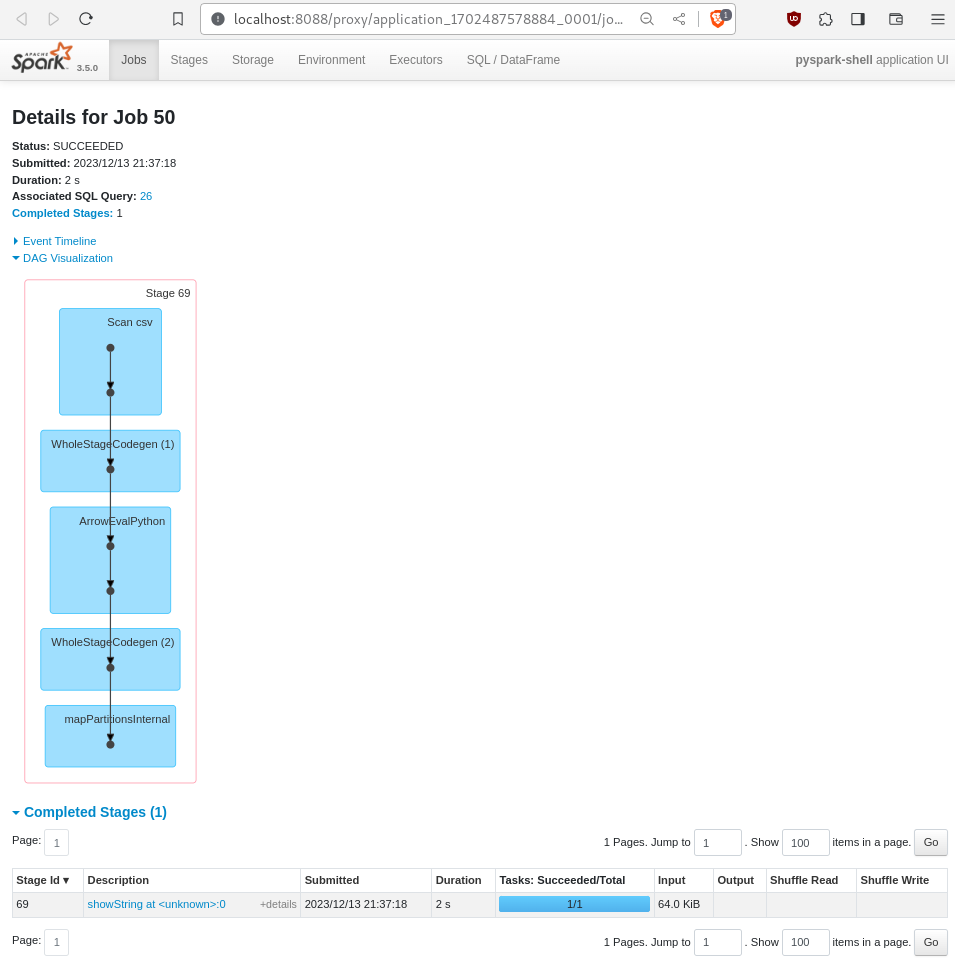

In [129]:
rating_predict = rating_predict.select('movieId', 'tag_as_token', 'predicted_rating')

avg_rating = ratings_df.groupBy(f.col("movieId"))\
    .agg(f.avg(f.col("rating")).alias("avg_rating"))

avg_rating_predict = rating_predict.groupBy(f.col("movieId"))\
    .agg(f.avg(f.col("predicted_rating")).alias("avg_predicted_rating"))

rmse = avg_rating_predict.join(
    avg_rating,
    on=["movieId"],
    how="inner",
).withColumn(
    'squared_error',
    (f.col("avg_rating") - f.col("avg_predicted_rating")) ** 2,
).agg(f.avg(f.col('squared_error')).alias("mean_squared_error")).withColumn(
    'rmse', f.col('mean_squared_error') ** (1/2)
)

rmse.show()

+------------------+------------------+
|mean_squared_error|              rmse|
+------------------+------------------+
|0.5629624337853129|0.7503082258547569|
+------------------+------------------+



- Напишите, чему равен корень суммы квадратов разностей (RMSE) между предсказанным и истинным значением рейтинга (напишите это на pyspark-е). Напишите, сколько было выполнено стейджей и тасок в рамках джобы. (10 баллов)

Инициированные джобы. Всего их 5, думаю их так много из-за плана запроса построенного спарком, и еще видимо 2 были были выделены на чтение датасетов.

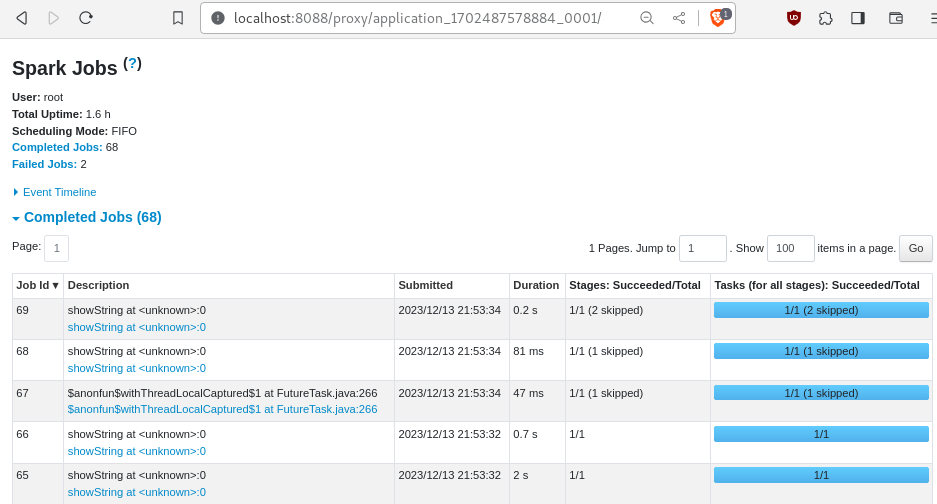

Всего было выполнено 5 тасок (поскольку некоторые пропускались):

1 stage, 1 task
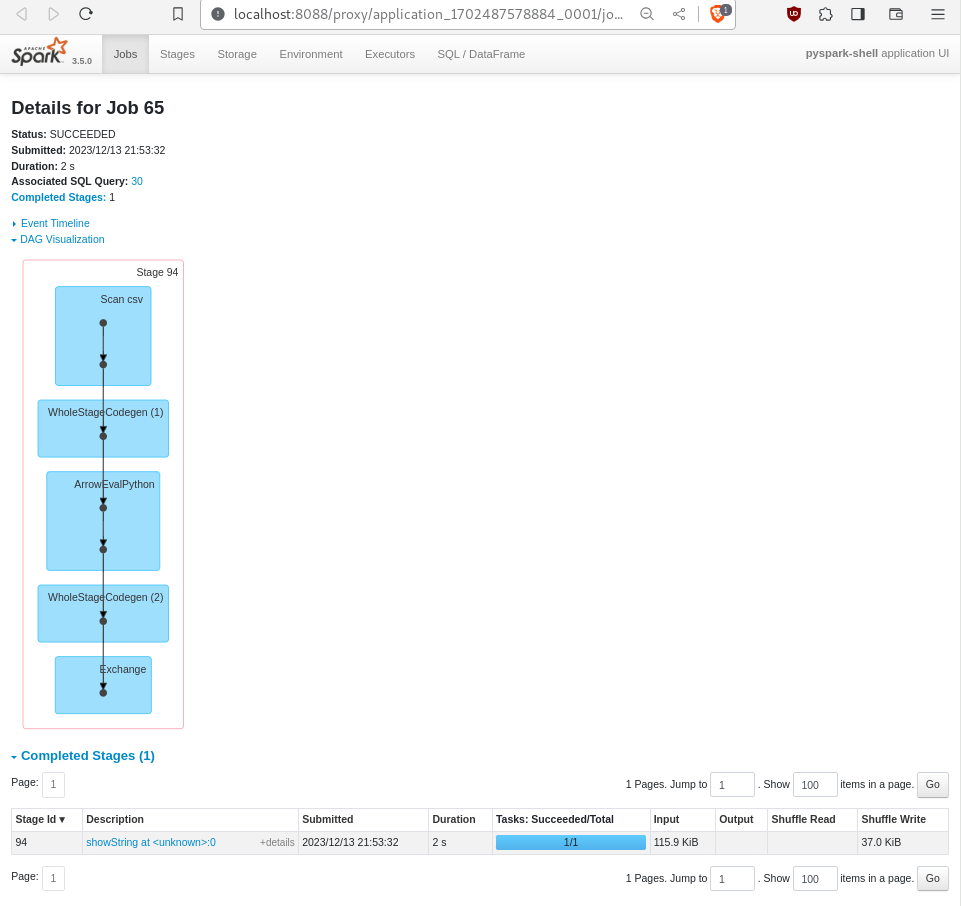

1 stage, 1 task
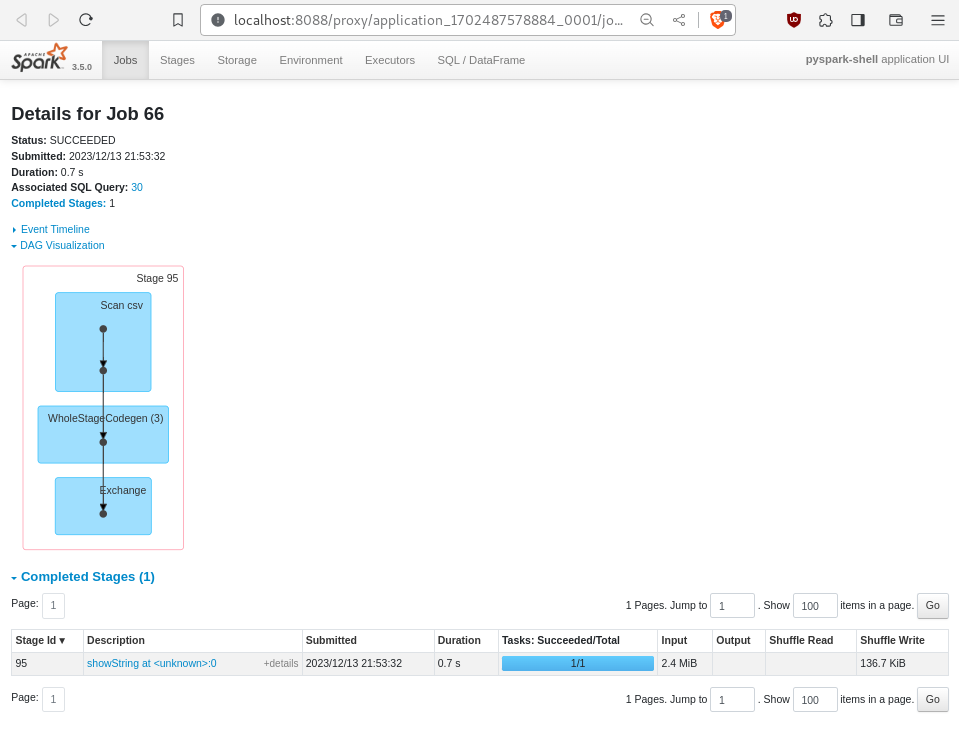

2 stage (1 skipped), 1 task
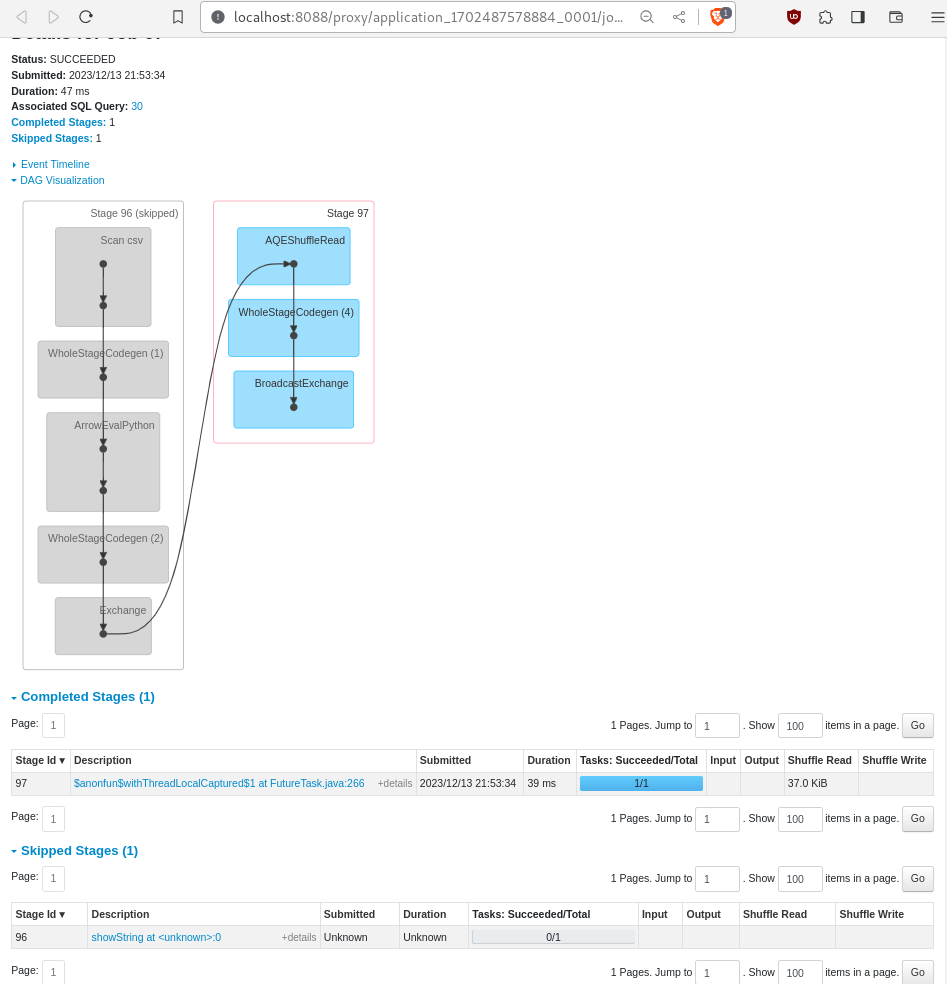

2 stage (1 skipped), 1 task
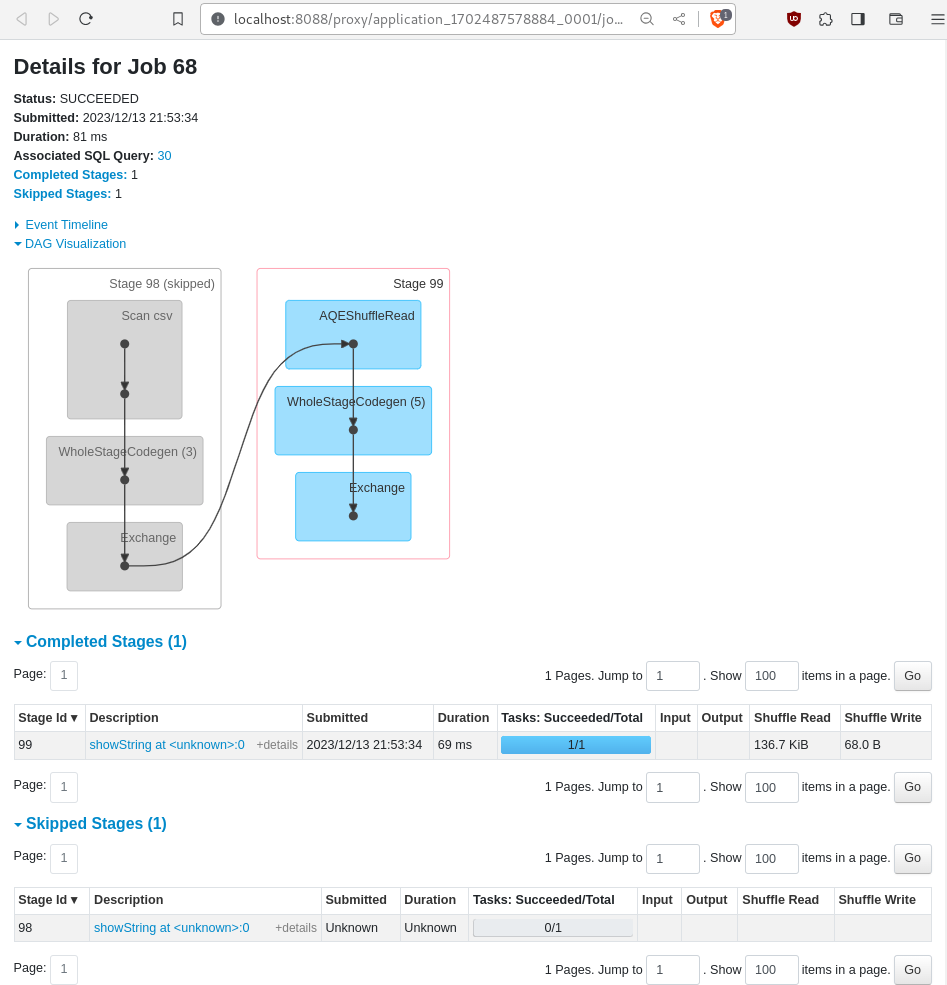

3 stage (2 skipped), 1 task
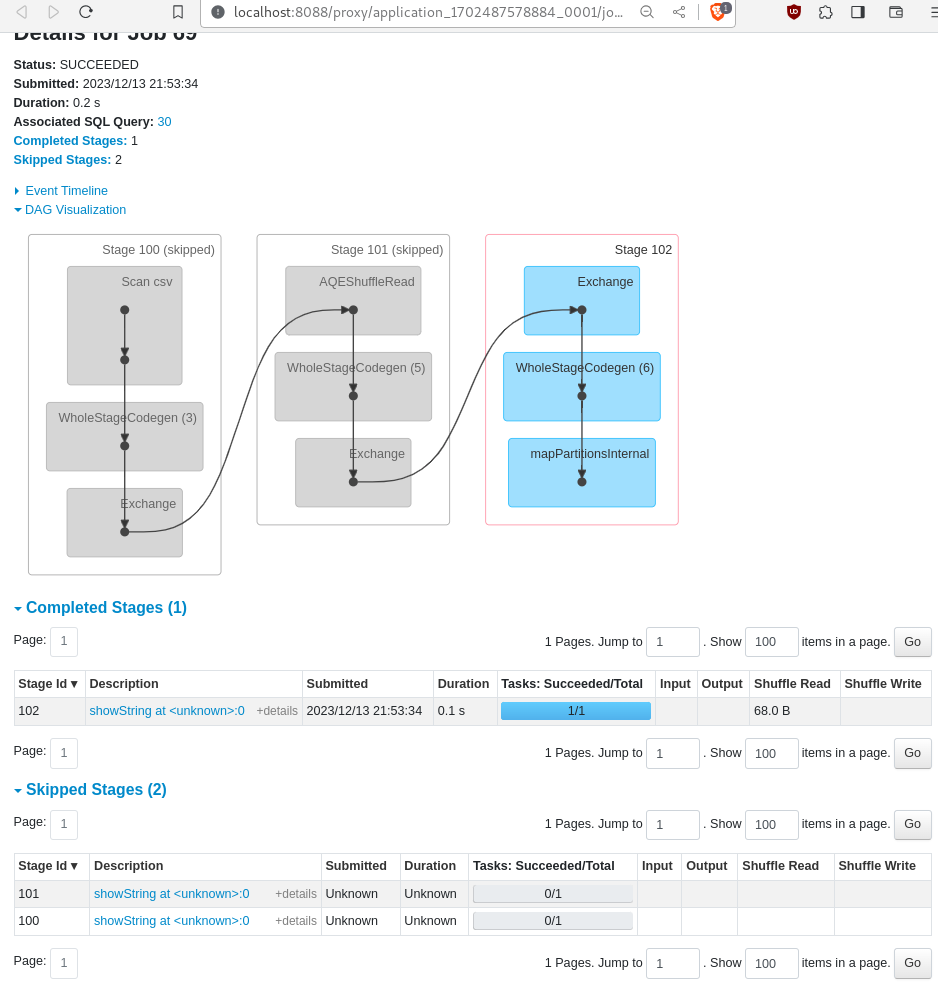